In [1]:
### dependencies ###
# !pip install cvxpy
# !pip install mystic

In [2]:
%matplotlib inline

# import cvxpy as cp
import numpy as np

import scipy.optimize as opt

import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
# # verify runway plot

# t_sim = 10 # seconds

# center_line_x = np.zeros((t_sim,))
# left_boundary_x = np.ones((t_sim,)) * -10
# right_boundary_x = np.ones((t_sim)) * 10

# center_line_y = np.linspace(0, t_sim, t_sim)
# left_boundary_y = np.linspace(0, t_sim, t_sim)
# right_boundary_y = np.linspace(0, t_sim, t_sim)

# plt.figure(figsize=(20, 3))
# plt.plot(center_line_y, center_line_x, color='gold', linestyle='--')
# plt.plot(left_boundary_y, left_boundary_x, color='black')
# plt.plot(right_boundary_y, right_boundary_x, color='black')

In [4]:
### function to plot trajectory ###

# TODO: add rotation matrix for data

def plot_trajectory(states, runway_length=(-100, 100), runway_boundaries=(-10, 10)):

    center_line_x = np.zeros((runway_length[1] - runway_length[0],))
    left_boundary_x = np.ones((runway_length[1] - runway_length[0],)) * runway_boundaries[0]
    right_boundary_x = np.ones((runway_length[1] - runway_length[0])) * runway_boundaries[1]

    center_line_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])
    left_boundary_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])
    right_boundary_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])

    plt.figure(figsize=(20, 3))
    plt.plot(center_line_y, center_line_x, color='gold', linestyle='--')
    plt.plot(left_boundary_y, left_boundary_x, color='black')
    plt.plot(right_boundary_y, right_boundary_x, color='black')
    
    colors = cm.rainbow(np.linspace(0, 1, int(len(states)//6)))
    for i in range(0, len(states), 6):
        x, y, _, h, _, _ = states[i:i+6]
        plt.plot(x, y, marker='o', markersize=5, color=colors[int(i//6)])   

### print states after getting result ###
        
def print_states(states):
    for i in range(0, len(states), 6):
        print("state {}:".format(int(i//6) + 1))
        output_states = np.round(states[i:i+6], 5)
        print("\tx: {}, y: {}, velocity: {}, heading: {}\n\tacceleration: {}, angular velocity: {}\n".\
              format(output_states[0], output_states[1], output_states[2], output_states[3], 
                     output_states[4], output_states[5]))

***States and Parameters Setup***

In [5]:
### states setup ###

init_heading = 90 # degrees
init_velocity = 0 # m/s

init_acceleration = 0 # m/s^2
init_turning = 0 # degrees/s

# start here at t = 0
init_x = 0
init_y = 0

# want to end here at t = sim_time
desired_x = 0
desired_y = 100

desired_velocity = 30 # m/s

acceleration_constraint = 5 # m/s^2
turning_constraint = 5 # degrees

time_step = 1
sim_time = 10

guess_range = (0, 10)

In [157]:
### xplane test states setup ###

init_heading = 270 + 54.331 # degrees
init_velocity = 0 # m/s

init_acceleration = 0 # m/s^2
init_turning = 0 # degrees/s

# start here at t = 0
init_x = 0
init_y = 0 

# want to end here at t = sim_time
desired_x = 2421
desired_y = -1737

desired_velocity = 30 # m/s

acceleration_constraint = 7 # m/s^2
turning_constraint = 100 # degrees

time_step = 1
sim_time = 10

guess_range = (0, 3)

***Controller Optimzed Over Controls***

In [160]:
def compute_states(init_state, controls, time_step=1):
    states = []
    x, y, v, h = init_state
    for i in range(0, len(controls), 2):
        a, w = controls[i:i+2]
        states = np.concatenate((states, [x, y, v, h, a, w]))
        test_heading = 54.331 + 40 + 270
        vx = (v * np.cos(np.radians(h))) + 0.1 * (30 * np.cos(np.radians(test_heading)))
        vy = (v * np.sin(np.radians(h))) + 0.1 * (30 * np.sin(np.radians(test_heading)))
        x += time_step * vx
        y += time_step * vy
        v += a * time_step
        h += w * time_step
    return states


def rejection_dist(desired_x, desired_y, curr_x, curr_y):
    a = np.array([desired_x, desired_y])
    b = np.array([curr_x, curr_y])
    projection = a@b / np.linalg.norm(a, ord=2)**2 * a
    proj_x, proj_y = projection
    return np.linalg.norm([curr_x - proj_x, curr_y - proj_y], ord=2) ** 2


def formulate_objective(init_states, desired_states, time_step=1, state_weight=0.1, 
                        control_weight=0.1, constraint_weight=0.1, dstate_weight=0.001):
    desired_x, desired_y, desired_v = desired_states
    def objective(params):
        states = compute_states(init_states, params, time_step=time_step)
        cost = control_weight * np.linalg.norm(np.vstack([params[0], params[1]]), ord=2) ** 2
        for i in range(6, len(states) - 6, 6):
            px, py, v, h, a, w = states[i:i+6]
            # closest centerline point
            cost += constraint_weight * rejection_dist(desired_x, desired_y, px, py)
            cost += control_weight * np.linalg.norm(np.vstack([a, w]), ord=2) ** 2
            cost += state_weight * np.linalg.norm(np.vstack([desired_x - px, desired_y - py]), ord=2)
            cost += 5 * np.linalg.norm([desired_v - v], ord=20)
        px, py, v, h, a, w = states[-6:]
        cost += dstate_weight * np.linalg.norm(np.vstack([desired_x - px, desired_y - py]), ord=2)
        cost += 5 * np.linalg.norm([desired_v - v], ord=2)
        return cost
    return objective


def formulate_guess(sim_time, guess_range=(0, 3)):
#     return np.random.randint(guess_range[0], guess_range[1], size=sim_time*2)
    return np.zeros((sim_time*2,))
    
    
state0 = [init_x, init_y, init_velocity, init_heading]
init_guess = formulate_guess(sim_time, guess_range=guess_range)
bounds = [(-acceleration_constraint, acceleration_constraint), 
          (-turning_constraint, turning_constraint)] * sim_time

obj = formulate_objective(state0, [desired_x, desired_y, desired_velocity], time_step=time_step, 
                          state_weight=1, constraint_weight=2, control_weight=0.5, dstate_weight=10)

result = opt.minimize(obj, init_guess, method='SLSQP', bounds=bounds,
                      options={'eps': 0.01, 'maxiter': 2000})
result

     fun: 51174.36650387185
     jac: array([-1.02589104e+02,  3.18283281e-02, -7.73593506e+01,  3.05802896e-02,
       -5.37084422e+01,  2.62636619e-02, -3.28668006e+01,  2.01157454e-02,
       -1.38625943e+01,  1.88391583e-02, -5.94930916e+00,  2.03720112e-02,
        5.76864550e-03,  1.02258477e-02,  1.61909411e-03,  2.57843931e-04,
       -4.20239521e-03,  2.80269887e-06,  0.00000000e+00,  0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 210
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([ 7.00000000e+00, -6.41061434e+00,  7.00000000e+00, -2.96059897e+00,
        7.00000000e+00,  7.37513119e-01,  7.00000000e+00,  2.46326482e+00,
        7.00000000e+00,  2.22214016e+00,  7.00000000e+00,  1.26866491e+00,
        5.98993533e+00,  5.57416295e-01, -8.64262990e-03,  2.66134763e-01,
       -5.00920179e+00, -4.99719819e-03,  0.00000000e+00,  0.00000000e+00])

state 1:
	x: 0.0, y: 0.0, velocity: 0.0, heading: 324.331
	acceleration: 0.0, angular velocity: 0.0

state 2:
	x: 2.99143, y: 0.22655, velocity: 0.0, heading: 324.331
	acceleration: 0.0, angular velocity: 0.0

state 3:
	x: 5.98287, y: 0.45311, velocity: 0.0, heading: 324.331
	acceleration: 0.0, angular velocity: 0.0

state 4:
	x: 8.9743, y: 0.67966, velocity: 0.0, heading: 324.331
	acceleration: 0.0, angular velocity: 0.0

state 5:
	x: 11.96573, y: 0.90622, velocity: 0.0, heading: 324.331
	acceleration: 0.0, angular velocity: 0.0

state 6:
	x: 14.95717, y: 1.13277, velocity: 0.0, heading: 324.331
	acceleration: 0.0, angular velocity: 0.0

state 7:
	x: 17.9486, y: 1.35933, velocity: 0.0, heading: 324.331
	acceleration: 0.0, angular velocity: 0.0

state 8:
	x: 20.94003, y: 1.58588, velocity: 0.0, heading: 324.331
	acceleration: 0.0, angular velocity: 0.0

state 9:
	x: 23.93147, y: 1.81244, velocity: 0.0, heading: 324.331
	acceleration: 0.0, angular velocity: 0.0

state 10:
	x: 26.9229, y

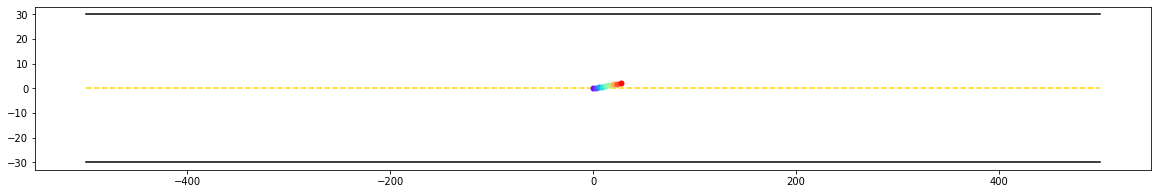

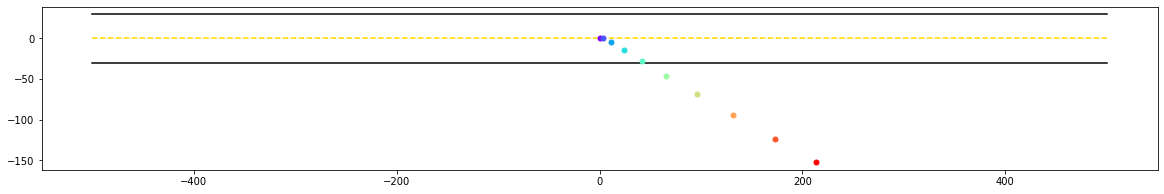

In [161]:
guess_traj = compute_states(state0, init_guess)
solved_traj = compute_states(state0, result.x)

plot_trajectory(guess_traj, runway_length=(-500, 500), runway_boundaries=(-30, 30))
plot_trajectory(solved_traj, runway_length=(-500, 500), runway_boundaries=(-30, 30))
 
print_states(guess_traj)
print_states(solved_traj)

***Controller Optimized Over States***

In [32]:
def shape_states(variables):
    states = variables[:4]
    controls = np.concatenate(([0, 0], variables[4:6]))
    controls[0] = states[2] * np.cos(np.radians(states[3]))
    controls[1] = states[2] * np.sin(np.radians(states[3]))
    return states, controls


def formulate_objective(desired_x, desired_y, desired_v, state_weight=0.1, control_weight=0.1, 
                        constraint_weight=0.1, dstate_weight=0.001):
    def objective(params):
        cost = 0
        cost += control_weight * np.linalg.norm(np.vstack([params[4], params[5]]), ord=2) ** 2
        for i in range(6, len(params) - 6, 6):
            px, py, v, h, a, w = params[i:i+6]
            cost += constraint_weight * np.linalg.norm([px], ord=2) ** 2
            cost += control_weight * np.linalg.norm(np.vstack([a, w]), ord=2) ** 2
            cost += np.linalg.norm([desired_v - v], ord=2) ** 2
        px, py, v, h, a, w = params[-6:]
        cost += dstate_weight * np.linalg.norm(np.vstack([desired_x - px, desired_y - py, desired_v - v]), ord=2)
        return cost
    return objective


def formulate_constraints(state0, sim_time, ts=1):
    def dynamic_constraints(params):
        errors = np.zeros((sim_time,))
        states_t, controls_t = shape_states(state0)
        errors[0] = np.linalg.norm(params[:4] - states_t, ord=2)
        for i in range(6, len(params), 6):    
            states_t1, controls_t1 = shape_states(params[i:i+6])
            # error[t+1] = norm(x_(t+1) - f(x_t, u_t))
            errors[int(i // 6)] = np.linalg.norm(states_t1 - (states_t + ts * controls_t), ord=2)
            states_t, controls_t = states_t1, controls_t1

        return np.sum(errors)
    return dynamic_constraints


def formulate_guess(state0, sim_time, random_seed=0, ts=1):
    
    guess_a = random.randint(guess_range[0], guess_range[1])
    guess_w = random.randint(guess_range[0], guess_range[1])
    state0_controlled = state0 + [guess_a, guess_w]
    init_state = state0_controlled[:]
    ix, iy, iv, ih, ia, iw = init_state
    
    for _ in range(sim_time - 1):
        
        new_x = ix + ts * iv * np.cos(np.radians(ih))
        new_y = iy + ts * iv * np.sin(np.radians(ih))
        new_v = iv + ts * ia
        new_h = ih + ts * iw
        guess_a = random.randint(guess_range[0], guess_range[1])
        guess_w = random.randint(guess_range[0], guess_range[1])
        init_state += [new_x, new_y, new_v, new_h, guess_a, guess_w]
        
        ix, iy, iv, ih, ia, iw = new_x, new_y, new_v, new_h, guess_a, guess_w
        
    return state0_controlled, np.array(init_state)

    
    
state0 = [init_x, init_y, init_velocity, init_heading]
state0, init_guess = formulate_guess(state0, sim_time, ts=time_step)

con = formulate_constraints(state0, sim_time, ts=time_step)
obj = formulate_objective(desired_x, desired_y, desired_velocity, state_weight=10, 
                          constraint_weight=1, control_weight=0.5, dstate_weight=10)

result = opt.minimize(obj, init_guess, method='SLSQP', 
                      constraints={"fun": con, "type": "eq"},
                      options={'eps': 0.01, 'maxiter': 1000})
result

     fun: 2059.9478441191254
     jac: array([  0.        ,   0.        ,   0.        ,   0.        ,
        -1.79830763,  -7.89644832,  -0.82776974,   0.        ,
       -53.57310098,   0.        ,  12.48209125,  -5.28944934,
        -1.75949195,   0.        , -28.69540605,   0.        ,
         3.90230615,  -4.51516693,  -4.2609952 ,   0.        ,
       -20.89617689,   0.        ,  -1.49039824,  -1.20846253,
        -4.26130911,   0.        , -23.91121595,   0.        ,
         3.66690299,  -0.20591489,  -3.60079313,   0.        ,
       -16.76677906,   0.        ,  -0.08670274,  -1.38935555,
        -2.60664365,   0.        , -16.93441857,   0.        ,
         0.61197785,  -3.00552451,  -0.63924566,   0.        ,
       -15.70414751,   0.        ,   0.49725112,  -2.74991147,
         3.69093254,   0.        , -14.74480706,   0.        ,
        -0.93455925,   0.64932516,   1.1618298 ,   9.75618014,
        -1.86190533,   0.        ,   0.        ,   0.        ])
 message: 'Iter

errors: [0.00000000e+00 3.41505692e+02 1.13347995e-02 3.68769359e-05
 8.42592693e-04 1.33567188e-02 1.53532837e-04 2.43278896e-03
 4.08759551e-03 1.29200452e-03] 

state 1:
	x: -0.03777, y: 0.02158, velocity: -0.02067, heading: 90.0295
	acceleration: -1.80331, angular velocity: -7.90145

state 2:
	x: -0.41888, y: -0.28925, velocity: 3.20845, heading: 99.90306
	acceleration: 12.47709, angular velocity: -5.29445

state 3:
	x: -0.88475, y: 2.82345, velocity: 15.6473, heading: 94.59484
	acceleration: 3.89731, angular velocity: -4.52017

state 4:
	x: -2.1355, y: 18.42456, velocity: 19.54691, heading: 90.07736
	acceleration: -1.4954, angular velocity: -1.21346

state 5:
	x: -2.13565, y: 37.9732, velocity: 18.03939, heading: 88.86181
	acceleration: 3.6619, angular velocity: -0.21091

state 6:
	x: -1.8054, y: 55.94254, velocity: 21.61161, heading: 88.66111
	acceleration: -0.0917, angular velocity: -1.39436

state 7:
	x: -1.30832, y: 77.55136, velocity: 21.52779, heading: 87.26236
	acceleration

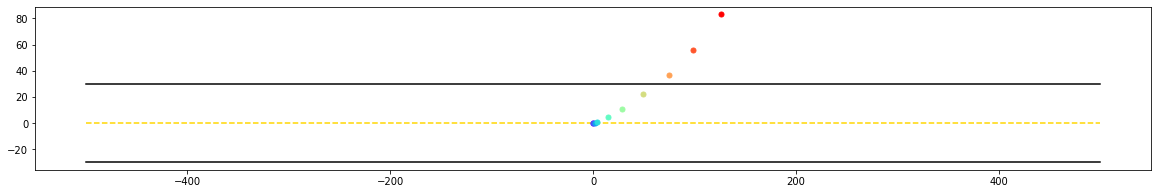

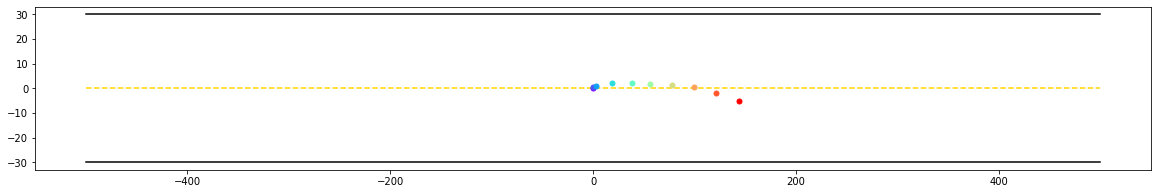

In [39]:
def get_controls(variables):
    controls = []
    for i in range(0, len(variables), 6):
        controls.append(variables[i+4])
        controls.append(variables[i+5])
    return controls

### verification for constraints ###

def verify_output(state0, params, sim_time, ts=1):
    errors = np.zeros((sim_time,))
    init_states, init_controls = shape_states(params[:6])
    errors[0] = np.linalg.norm(params[:4] - init_states, ord=2) ** 2

    for i in range(6, len(params), 6):    
        next_states, next_controls = shape_states(params[i:i+6])
        errors[int(i // 6)] = np.linalg.norm(next_states - (init_states + ts * init_controls), ord=2) ** 2
        init_states, init_controls = next_states, next_controls

    return errors

print("errors:", verify_output(state0, result.x, sim_time, ts=time_step), "\n")

plot_trajectory(init_guess, runway_length=(-500, 500), runway_boundaries=(-30, 30))
plot_trajectory(result.x, runway_length=(-500, 500), runway_boundaries=(-30, 30))
        
print_states(result.x)